# Using A Genetic Algorithm to Design a Perfect Keyboard Layout #

## Etienne Cauchi <br> Student Code: 5603H

In order to make the required project as reader-friendly as possible, I tried to modularise it as much as possible. I built functions first, which I then run in the final group of code blocks.

### Pre-Requisites

I used the Project Gutenberg library found at: https://pypi.org/project/Gutenberg/ to ease access to the Gutenberg dataset.

In [91]:
import random
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg
from PIL import Image
import matplotlib.pyplot as plt

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\raylo\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


### Creating the First Population


To create the first population, I randomly created permutations of the keys. This was done as many times as the user requests, since the size of the population is passed as a parameter to the function.

In [ ]:
def firstPopulation(populationSize):
    keyboard = list('abcdefghijklmnopqrstuvwxyz,./;')
    population = []
    for x in range(populationSize):
        #Slicing the keyboard to make the random shuffle method as random as possible
        keyboard = keyboard[:]
        random.shuffle(keyboard)
        population.append(keyboard)
    return population

### Creating Subsequent Populations

Single-Point Crossover was implemented quite consistently with how it was shown on the video, since I couldn't find an alternative method that worked as well and as efficiently.

<br>
Mutation was implemented in this function. If true is passed as a parameter, there is a 7% chance that 2 keys switch position.

In [34]:
def singlePointCrossover(half1, half2, mutation):
    child = ['#' for x in range(30)]
    
    #Determines how many to choose from the first keyboard
    howMany = random.randint(0, 29)
    
    # Determines where the starting point is for the crossover
    keyAllocator = random.randint(0, 29)

    #add keys from half 1
    for x in range(howMany):
        if keyAllocator > 29:
            keyAllocator = 0
        child[keyAllocator] = half1[keyAllocator]
        keyAllocator += 1

    #add remaining keys from half2
    keyAllocator2 = keyAllocator  
    while '#' in child:
        if keyAllocator > 29:
            keyAllocator = 0
        if keyAllocator2 > 29:
            keyAllocator2 = 0
        toAdd = half2[keyAllocator]
        if toAdd in child:
            keyAllocator += 1
            continue
        child[keyAllocator2] = half2[keyAllocator] 
        keyAllocator += 1
        keyAllocator2 += 1

        #mutation
        if mutation:
            if random.randint(1, 100) < 8:
                swap1 = random.randint(0, 29)
                swap2 = random.randint(0, 29)
                if swap1 == swap2:
                    swap2 = random.randint(0,29)

                temp = child[swap2]
                child[swap2] = child[swap1]
                child[swap1] = temp
            
    return child

Two-Point Crossover works in a way similarly to single point crossover. I did not want to spend more time than I had allocated to this project trying to find the error I have in this function, so, I left this function here, as it almost works, but does not quite.

In [ ]:
def twoPointCrossover(half1, half2, mutation):
    child = ['#' for x in range(0, 30)]
    
    #Determines how many to choose from the first keyboard
    howMany1 = random.randint(0, 29)
    howMany2 = random.randint(0, 29-howMany1)
    
    # Determines where the starting point is for the crossover
    keyAllocator = random.randint(0, 29)

    #add keys from half 1
    for x in range(howMany1):
        if keyAllocator > 29:
            keyAllocator = 0
        child[keyAllocator] = half1[keyAllocator]
        keyAllocator += 1

    #add remaining keys from half2
    keyAllocator2 = keyAllocator 
    for x in range(howMany2):
        while True:
            if keyAllocator2 > 29:
                keyAllocator2 = 0
            if keyAllocator > 29:
                keyAllocator = 0
            toAdd = half2[keyAllocator]
            if toAdd in child:
                keyAllocator += 1
                continue
            else:
                break

        child[keyAllocator2] = half2[keyAllocator] 
        keyAllocator += 1
        keyAllocator2 += 1


        keyAllocator3 = keyAllocator
        while '#' in child:
            if keyAllocator3 > 29:
                keyAllocator3 = 0
            if keyAllocator > 29:
                keyAllocator = 0
            toAdd = half2[keyAllocator]
            if toAdd in child:
                keyAllocator += 1
                continue
            child[keyAllocator3] = half2[keyAllocator]
            keyAllocator += 1
            keyAllocator3 += 1

        if mutation:
            if random.randint(1,100) < 8:
                swap1 = random.randint(0,29)
                swap2 = random.randint(0, 29)
                if swap1 == swap2:
                    swap2 = random.randint(0,29)

                temp = child[swap2]
                child[swap2] = child[swap1]
                child[swap1] = temp
    return child

To create a population from another population, the following is performed:
<ol>

<li>The previous population (taken in as a parameter) is sorted according to fitness (in this case, distance taken to type the text necessary).</li>

<li>Elitism is implemented. This is done by moving the fittest 15% of the last population into the new generation without any crossover.</li>

<li> From the previous population, the program takes 2 random keyboards from the top 45% and implements changeover, depending on if the two_point parameter is True or False. </li>

<li> Step 3 is repeated for the top 80% of the population size. </li>
</ol>

In [8]:
def more_Generations(sortedPreviousPopulation, populationSize, mutation, elitism, two_point):
    new_Generation = []

    #implementing elitism: keeping best 20% to move onto the next generation
    if elitism:
        for i in range(int(populationSize*0.2)):
            new_Generation.append(sortedPreviousPopulation[i])

    ##creating the other 80% of the new generation from 2 halves of the top 45% of the current generation
    population_cut_off = int(populationSize*0.45)
    for x in range(int(populationSize*0.8)):
        half1 = random.choice(sortedPreviousPopulation[0:population_cut_off])
        half2 = random.choice(sortedPreviousPopulation[0:population_cut_off])

        if (two_point):
            new_Generation.append(twoPointCrossover(half1, half2, mutation))
        else: 
            new_Generation.append(singlePointCrossover(half1, half2, mutation))
    return new_Generation

### Grouping Keys

I used a dictionary to group the key_number on the keyboard to which finger clicks it in standard keyboard usage. I also used a dictionary to mark which keys were the fingers' home keys. The keys were labelled left-to-right, top-to-bottom, starting from 1 and ending at 30.

In [9]:
finger_guide = {
    "space": ["left_thumb", "right_thumb"],
    0: "left_finger_2",
    10: "left_finger_2",
    20: "left_finger_2",    
    1: "left_finger_3",
    11: "left_finger_3",
    21: "left_finger_3",
    2: "left_finger_4",
    12: "left_finger_4",
    22: "left_finger_4",
    3: "left_finger_5",
    4: "left_finger_5",
    13: "left_finger_5",
    14: "left_finger_5",
    23: "left_finger_5",
    24: "left_finger_5",
    5: "right_finger_2",
    6: "right_finger_2",
    15: "right_finger_2",
    16: "right_finger_2",
    25: "right_finger_2",
    26: "right_finger_2",
    7: "right_finger_3",
    17: "right_finger_3",
    27: "right_finger_3",
    8: "right_finger_4",
    18: "right_finger_4",
    28: "right_finger_4",
    9: "right_finger_5",
    19: "right_finger_5",
    29: "right_finger_5"
}

home_keys = {
    "left_thumb": "space",
    "right_thumb": "space",
    "left_finger_2": 10,
    "left_finger_3": 11,
    "left_finger_4": 12,
    "left_finger_5": 13,
    "right_finger_2": 16,
    "right_finger_3": 17,
    "right_finger_4": 18,
    "right_finger_5": 19
}

### Accessing and Cleaning the Dataset/Corpus

'keyboard_characters' is a list of all characters we will be taking into consideration; we will not be taking characters like '[', '-', etc. into consideration, mainly because the video did not, and therefore, if I were to take them into consideration, I would not be able to compare results with those of the video. I also took out the space character, since the space is the only button pressed by the thumbs and will therefore not contribute to any change in the fitness score. 

In [10]:
keyboard_characters = list('abcdefghijklmnopqrstuvwxyz,./;<>:?')

In the code-block below, I went through my chosen text corpus (NLTK's library of Gutenberg books) and I did the following:
- took out all the characters that are not in the list above (keyboard_characters)
- the chatacters that were left were made lowercase, since the Shift key is not paid much attention in the video, and as I mentioned before, I tried to stay consistent to the video
- changed the Shift symbol keys (<, >, :, ?) to their non-shift counterparts for the same reasons stated above
- snipped the corpus to only contain the first 240,000 characters, since it's around the same the video maker had in their video.



In [11]:
my_text_corpus = [x.lower() for x in gutenberg.raw() if x in keyboard_characters or x.lower() in keyboard_characters]
shift_keys_fixed = []

for char in my_text_corpus:
    if char == '<':
        shift_keys_fixed.append(',')
    
    elif char == '>':
        shift_keys_fixed.append('.')
    
    elif char == ':':
        shift_keys_fixed.append(';')
    
    elif char == '?':
        shift_keys_fixed.append('/')
    
    else:
        shift_keys_fixed.append(char)

my_text_corpus = ''.join(shift_keys_fixed)
my_text_corpus = my_text_corpus[0:240000]


### Distances between every key combination

I took the key distances used in the video as standard, since I saw these to be accurate and for the study to be consistent with that taken out on the video, so that I could be able to compare results. I placed the distances needed to travel between every combination of keys in a dictionary called distance.
I labelled the distance variables by the colours they are in in the video.

In [12]:
arrows = {"same-key": 0, "green": 1, "blue": 1.032, "red": 1.118, "purple": 2.138, "orange": 1.247, "pink": 1.605, "brown": 1.803, "darker-green": 2.661, "yellow": 2.015}

distance = {
    0: {
        0: arrows["same-key"],
        10: arrows["blue"],
        20: arrows["purple"]
    },

    1: {
        1: arrows["same-key"],
        11: arrows["blue"],
        21: arrows["purple"]
    },

    2: {
        2: arrows["same-key"],
        12: arrows["blue"],
        22: arrows["purple"]
    },

    3: {
        3: arrows["same-key"],
        4: arrows["green"],
        13: arrows["blue"],
        14: arrows["pink"],
        23: arrows["purple"],
        24: arrows["darker-green"]
    },

    4: {
        3: arrows["green"],
        4: arrows["same-key"],
        13: arrows["orange"],
        14: arrows["blue"],
        23: arrows["yellow"],
        24: arrows["purple"] 
    },

    5: {
        5: arrows["same-key"],
        6: arrows["green"],
        15: arrows["blue"],
        16: arrows["pink"],
        25: arrows["purple"],
        26: arrows["darker-green"]
    },

    6: {
        5: arrows["green"],
        6: arrows["same-key"],
        15: arrows["orange"],
        16: arrows["blue"],
        25: arrows["yellow"],
        26: arrows["purple"] 
    },

    7: {
        7: arrows["same-key"],
        17: arrows["blue"],
        27: arrows["purple"]
    },

    8:{
        8: arrows["same-key"],
        18: arrows["blue"],
        28: arrows["purple"]
    },

    9: {
        9: arrows["same-key"],
        19: arrows["blue"],
        29: arrows["purple"]
    },

    10: {
        0: arrows["blue"],
        10: arrows["same-key"],
        20: arrows["red"]       
    },

    11: {
        1: arrows["blue"],
        11: arrows["same-key"],
        21: arrows["red"]       
    },

    12: {
        2: arrows["blue"],
        12: arrows["same-key"],
        22: arrows["red"]
    },

    13:{
        3: arrows["blue"],
        4: arrows["orange"],
        13: arrows["same-key"],
        14: arrows["green"],
        23: arrows["red"],
        24: arrows["brown"]
    },

    14:{
        3: arrows["pink"],
        4: arrows["blue"],
        13: arrows["green"],
        14: arrows["same-key"],
        23: arrows["red"],
        24: arrows["red"]
    },

    15: {
        5: arrows["blue"],
        6: arrows["orange"],
        15: arrows["same-key"],
        16: arrows["green"],
        25: arrows["red"],
        26: arrows["brown"]
    },

    16: {
        5: arrows["pink"],
        6: arrows["blue"],
        15: arrows["green"],
        16: arrows["same-key"],
        25: arrows["red"],
        26: arrows["red"]
    },

    17: {
        7: arrows["blue"],
        17: arrows["same-key"],
        27: arrows["red"]
    },

    18: {
        8: arrows["blue"],
        18: arrows["same-key"],
        28: arrows["red"]
    },

    19: {
        9: arrows["blue"],
        19: arrows["same-key"],
        29: arrows["red"]
    },

    20:{
        0: arrows["purple"],
        10: arrows["red"],
        20: arrows["same-key"]
    },

    21: {
        1: arrows["purple"],
        11: arrows["red"],
        21: arrows["same-key"]
    },

    22: {
        2: arrows["purple"],
        12: arrows["red"],
        22: arrows["same-key"]
    },

    23:{
        3: arrows["purple"],
        4: arrows["yellow"],
        13: arrows["red"],
        14: arrows["red"],
        23: arrows["same-key"],
        24: arrows["green"]
    },

    24:{
        3: arrows["darker-green"],
        4: arrows["purple"],
        13: arrows["brown"],
        14: arrows["red"],
        23: arrows["green"],
        24: arrows["same-key"]
    },

    25: {
        5: arrows["purple"],
        6: arrows["yellow"],
        15: arrows["red"],
        16: arrows["red"],
        25: arrows["same-key"],
        26: arrows["green"]
    },

    26: {
        5: arrows["darker-green"],
        6: arrows["purple"],
        15: arrows["brown"],
        16: arrows["red"],
        25: arrows["green"],
        26: arrows["same-key"]
    },

    27: {
        7: arrows["purple"],
        17: arrows["red"],
        27: arrows["same-key"]
    },

    28: {
        8: arrows["purple"],
        18: arrows["red"],
        28: arrows["same-key"]
    },

    29: {
        9: arrows["purple"],
        19: arrows["red"],
        29: arrows["same-key"]
    }
}

### Calculating Fitness

I created a function to calculate the fitness score of any keyboard passed to it as a list. The other parameters this takes includes the test text it needs to type and the placements of the home keys on the keyboard along with a dictionary storing the finger supposed to press every button and another dictionary storing the distances between every key and every other key the approprite finger can move to.
<br><br>
This function first initialises a dictionary to the home key positions of the keyboard. This dictionary's values track where every finger is on the keyboard at that point in time. <br>

After that, it iterated through every character in the text corpus, and for every character does the following:
> 1. Looks for the finger that is supposed to press that character. This is done by doing the following:
>> - checks the index of the character in the current keyboard.
>> - checks the dictionary key of that index in finger_guide, therefore finding which finger pushes that character. 
>> - stores this value in finger_to_use
> 2. Checks if that finger is currently on the key it needs to press and executes as follows:
>> - if true: it will not add any distance, as the finger did not travel to reach the button
>> - if false: 
>>>1. the distance needed for the finger to travel to that key is added to the total_distance
>>>2. the current finger placement of that finger is moved to its new placement

The function will then return this keyboard's fitness score.

In [13]:
def calculate_distance(keyboard, text, home_keys, finger_guide, distance):
    current_finger_placement = home_keys
    total_distance = 0
    for char in text:
        index_in_keyboard = keyboard.index(char)
        finger_to_use = finger_guide[index_in_keyboard]
        if current_finger_placement[finger_to_use] == char:
            continue
        else:
            total_distance += distance[current_finger_placement[finger_to_use]][index_in_keyboard]
            current_finger_placement[finger_to_use] = index_in_keyboard  
    return total_distance


### Running the Algorithm

I implemented the following function which is able to collect every other function we've made up till now. The algorithm first creats the first population. After that, for the amount of times passed as a parameter, the more_Generations function is run. The fittest score in every population was saved, to be able to analyse.

In [77]:
def run_algorithm(populationSize, generations, mutation, elitism, two_point):
    best_fitness_per_gen = []
    current_gen = []

    current_gen = firstPopulation(populationSize)
    temp_fitness_per_gen = {}

    i = 0
    for x in current_gen:
        temp_fitness_per_gen.update({i: calculate_distance(x, my_text_corpus, home_keys, finger_guide, distance)})
        i += 1


    temp_fitness_per_gen = sorted(temp_fitness_per_gen.items(), key=lambda y: y[1])
    best_fitness_per_gen.append(temp_fitness_per_gen[0][1])
    sorted_pop = [current_gen[x[0]] for x in temp_fitness_per_gen]

    for x in range(generations-1):
        current_gen = more_Generations(sorted_pop, populationSize, mutation, elitism, two_point)
        temp_fitness_per_gen = {}

        i = 0
        for x in current_gen:
            temp_fitness_per_gen.update({i: calculate_distance(x, my_text_corpus, home_keys, finger_guide, distance)})
            i += 1
        
        temp_fitness_per_gen = sorted(temp_fitness_per_gen.items(), key=lambda y: y[1])
        best_fitness_per_gen.append(temp_fitness_per_gen[0][1])
        sorted_pop = [current_gen[x[0]] for x in temp_fitness_per_gen]
    return [sorted_pop, best_fitness_per_gen]


In [59]:
allOn = run_algorithm(100, 500, True, True, False)
mutation = run_algorithm(100, 500, True, False, False)
elitism = run_algorithm(100, 500, False, True, False)
nothing = run_algorithm(100, 500, False, False, False)
lowPopulation = run_algorithm(10, 500, False, False, False)

The best result from every variation of parameters is sorted.

In [88]:
best_results = {"all-on": min(allOn[1]), "mutation": min(mutation[1]), "elitism": min(elitism[1]), "nothing": min(nothing[1]),"lowPopulation": min(lowPopulation[1])}
best_results = dict(sorted(best_results.items(), key=lambda item: item[1]))

{'nothing': 139618.55200022887, 'lowPopulation': 140303.65700023682, 'elitism': 140821.44300024636, 'mutation': 141599.96600026466, 'all-on': 142584.6360002034}


The distance taken by a qwerty keyboard to type the corpus is calculated.

In [79]:
qwerty = list('qwertyuiopasdfghjkl;zxcvbnm,./')
qwerty_distance = calculate_distance(qwerty, my_text_corpus, home_keys, finger_guide, distance)


### Analysing Results

The most efficient keyboard layout can be found below. It shares many similarities with that of the creator; mainly having an almost identical set of keys as my home row, with the only change being 'h' being in my home row where 'd' is in the user's. 

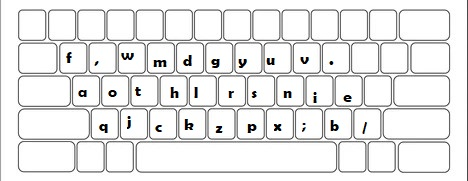

In [92]:
Image.open("./my_keyboard.jpg")

When compared to QWERTY, my keyboard is over 39% more fit.

In [101]:
print(qwerty_distance, "QWERTY Layout")
print(best_results["nothing"], "My Layout")
print("My keyboard is ", (qwerty_distance*100/best_results["nothing"]-100), "% more fit than the standard QWERTY layout.")


194140.9650003194 QWERTY Layout
139618.55200022887 My Layout
My keyboard is  39.05098013049238 % more fit than the standard QWERTY layout.


#### Visualisations

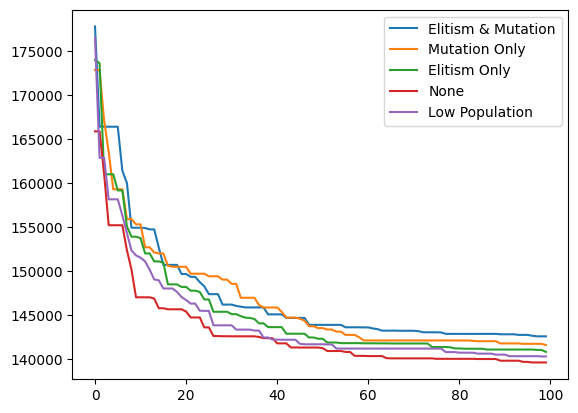

In [114]:
plt.plot(allOn[1], label = "Elitism & Mutation")
plt.plot(mutation[1], label="Mutation Only")
plt.plot(elitism[1], label="Elitism Only")
plt.plot(nothing[1], label="None")
plt.plot(lowPopulation[1], label="Low Population")
plt.legend()


### Conclusion

Using a Jupyter notebook, as opposed to Python scripts allowed me to explain my thoughts throughout and therefore, I feel like I have 'set the scene' as well as I could have.
<br><br>
I used the NLTK Gutenberg text corpus as I had already used NLTK previously, and was familiar with the use and application of it.
<br><br>
I used lists to store my chromosones as they are simple to use and allow for duplicates, which occurs when I am initialising a new chromosone from 2 parents.
<br><br>
I implemented both single-point and 2-point crossover, making the option available to the end-user, to allow for as much and as deep analysis as needed. Single-point analysis was implemented similarly to how the video did it, as the code was shown during the video and it is the most direct way to get there; and therefore, it works perfectly. When it comes to 2-point crossover, I implemented most of it in a good manner, but have yet to figure out 1 bug when it comes to list subscripting.
<br><br>
I implemented mutation by making it available to the user as a parameter that they can set, but I set the probability of a mutation at 7%. This can easily be made variable, by changing the parameter from a boolean to a decimal number, but for this exercise, I did not see it as necessary.
<br><br>
Elitism was implemented, like everything else, as according to the user. A boolean was passed to the methods, asking if they wanted to use elitism. If true, a 15% rate was used. Like mutation, it's very easy to make this variable, but I did not find this important, as this exercise was made mostly for our own use and therefore, I could go into the code and change it for myself, if I so want to. 

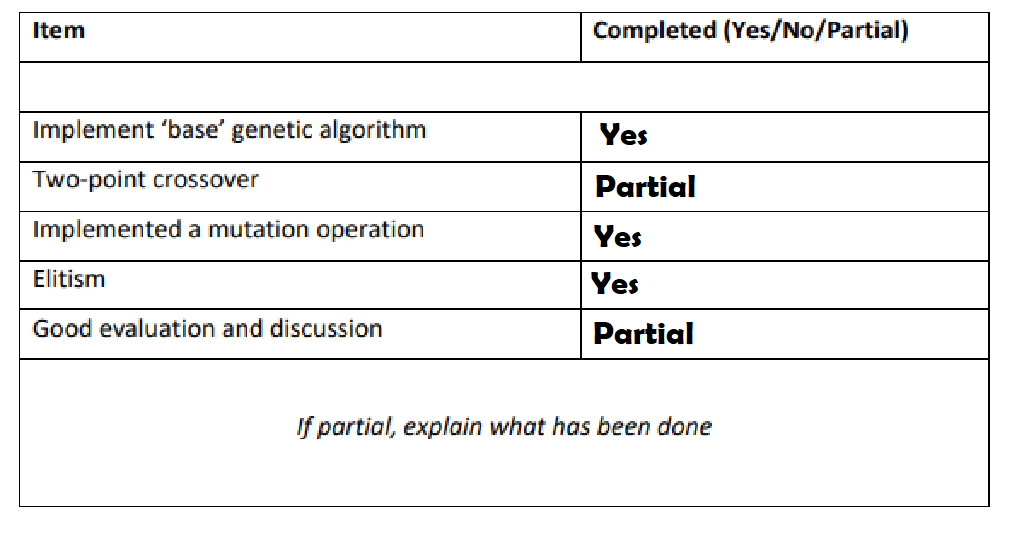

In [117]:
Image.open("./Completion.png")

The partial parts are explained in the markdown block just above. As for the evaluation, I did not find enough time in the time I allocated for this assignment to do more thorough experimentation; had this been the whole assessment for the study-unit, I would have had more time to find correlations between variables and to test more agressively.